CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn             # For creating NN layers
import torch.nn.functional as F
import torch.optim as optim       # Optimizers
from torchvision import datasets, transforms # MNIST database

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print(f"CUDA Available?\n{cuda}")

CUDA Available?
True


CODE BLOCK: 3

Transforms are preparation operations applied to dataset before feeding it to the neural network.

Below, we are specifying the parameters and conditions for the train/test data.


In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

The test/train datasets are split in 60k/10k. This is a standard split and the idea is to have the same benchmark across papers.

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

print(len(train_data), len(test_data))

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.55MB/s]

60000 10000


CODE BLOCK: 5

In [5]:
batch_size = 48

#kwargs = keyword arguments
kwargs = {'batch_size': batch_size,
          'shuffle': False,
          'num_workers': 2,
          'pin_memory': True}

# Data loader is PyTorch helper to iterate over dataset in batches
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

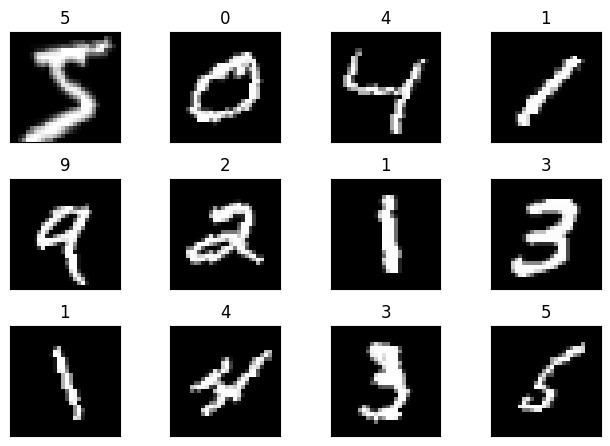

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1) # Dislay in 3 rows and 4 columns
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [7]:
class Net(nn.Module):
    # This defines the structure of the NN.
    def __init__(self):
        channel_1_depth = 32
        channel_2_depth = 32
        channel_3_depth = 48

        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, channel_1_depth, kernel_size=3) # 1 channel - grayscale, with 32 filters of 3x3 each
        self.conv2 = nn.Conv2d(channel_1_depth, channel_2_depth, kernel_size=3)
        self.conv3 = nn.Conv2d(channel_2_depth, channel_3_depth, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(channel_1_depth)
        self.bn2 = nn.BatchNorm2d(channel_2_depth)
        self.bn3 = nn.BatchNorm2d(channel_3_depth)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channel_3_depth, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(F.max_pool2d(self.bn2(self.conv2(x)), 2)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.bn3(F.max_pool2d(x,2)))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [9]:
from tqdm import tqdm # Progress bar animation library

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device) # Move to GPU, if available.

    optimizer.zero_grad() # By default, the gradients accumulate every batch. So, should be reset.

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()

    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad(): #	In testing, we don’t update weights, so we don’t need gradients.
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = Net().to(device)
#	Optimizer: tells the model how to adjust its weights during training
optimizer = optim.Adam(model.parameters(), lr=0.0055)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Using device: cuda
Epoch 1


Train: Loss=0.0291 Batch_id=1249 Accuracy=92.70: 100%|██████████| 1250/1250 [00:29<00:00, 42.47it/s]


Test set: Average loss: 0.0035, Accuracy: 56955/60000 (94.92%)

Epoch 2


Train: Loss=0.0794 Batch_id=1249 Accuracy=96.60: 100%|██████████| 1250/1250 [00:28<00:00, 44.40it/s]


Test set: Average loss: 0.0028, Accuracy: 57565/60000 (95.94%)

Epoch 3


Train: Loss=0.0176 Batch_id=1249 Accuracy=97.06: 100%|██████████| 1250/1250 [00:27<00:00, 45.79it/s]


Test set: Average loss: 0.0022, Accuracy: 58022/60000 (96.70%)

Epoch 4


Train: Loss=0.0323 Batch_id=1249 Accuracy=97.38: 100%|██████████| 1250/1250 [00:27<00:00, 45.61it/s]


Test set: Average loss: 0.0020, Accuracy: 58241/60000 (97.07%)

Epoch 5


Train: Loss=0.0062 Batch_id=1249 Accuracy=97.54: 100%|██████████| 1250/1250 [00:29<00:00, 42.47it/s]


Test set: Average loss: 0.0015, Accuracy: 58707/60000 (97.84%)

Epoch 6


Train: Loss=0.0088 Batch_id=1249 Accuracy=97.79: 100%|██████████| 1250/1250 [00:27<00:00, 45.86it/s]


Test set: Average loss: 0.0018, Accuracy: 58422/60000 (97.37%)

Epoch 7


Train: Loss=0.0032 Batch_id=1249 Accuracy=97.96: 100%|██████████| 1250/1250 [00:26<00:00, 47.26it/s]


Test set: Average loss: 0.0013, Accuracy: 58786/60000 (97.98%)

Epoch 8


Train: Loss=0.0075 Batch_id=1249 Accuracy=98.10: 100%|██████████| 1250/1250 [00:26<00:00, 46.47it/s]


Test set: Average loss: 0.0013, Accuracy: 58826/60000 (98.04%)

Epoch 9


Train: Loss=0.0093 Batch_id=1249 Accuracy=98.06: 100%|██████████| 1250/1250 [00:26<00:00, 46.85it/s]


Test set: Average loss: 0.0012, Accuracy: 58944/60000 (98.24%)

Epoch 10


Train: Loss=0.0055 Batch_id=1249 Accuracy=98.16: 100%|██████████| 1250/1250 [00:26<00:00, 46.69it/s]


Test set: Average loss: 0.0012, Accuracy: 58938/60000 (98.23%)

Epoch 11


Train: Loss=0.0047 Batch_id=1249 Accuracy=98.27: 100%|██████████| 1250/1250 [00:27<00:00, 45.30it/s]


Test set: Average loss: 0.0012, Accuracy: 58926/60000 (98.21%)

Epoch 12


Train: Loss=0.0156 Batch_id=1249 Accuracy=98.19: 100%|██████████| 1250/1250 [00:27<00:00, 46.28it/s]


Test set: Average loss: 0.0016, Accuracy: 58602/60000 (97.67%)

Epoch 13


Train: Loss=0.0069 Batch_id=1249 Accuracy=98.30: 100%|██████████| 1250/1250 [00:27<00:00, 45.79it/s]


Test set: Average loss: 0.0013, Accuracy: 58801/60000 (98.00%)

Epoch 14


Train: Loss=0.0097 Batch_id=1249 Accuracy=98.29: 100%|██████████| 1250/1250 [00:27<00:00, 46.12it/s]


Test set: Average loss: 0.0011, Accuracy: 59000/60000 (98.33%)

Epoch 15


Train: Loss=0.0041 Batch_id=1249 Accuracy=98.45: 100%|██████████| 1250/1250 [00:27<00:00, 45.50it/s]


Test set: Average loss: 0.0009, Accuracy: 59135/60000 (98.56%)

Epoch 16


Train: Loss=0.0110 Batch_id=1249 Accuracy=98.78: 100%|██████████| 1250/1250 [00:26<00:00, 46.66it/s]


Test set: Average loss: 0.0007, Accuracy: 59323/60000 (98.87%)

Epoch 17


Train: Loss=0.0019 Batch_id=1249 Accuracy=98.88: 100%|██████████| 1250/1250 [00:26<00:00, 46.47it/s]


Test set: Average loss: 0.0007, Accuracy: 59358/60000 (98.93%)

Epoch 18


Train: Loss=0.0092 Batch_id=1249 Accuracy=98.94: 100%|██████████| 1250/1250 [00:27<00:00, 46.22it/s]


Test set: Average loss: 0.0007, Accuracy: 59385/60000 (98.97%)

Epoch 19


Train: Loss=0.0045 Batch_id=1249 Accuracy=98.96: 100%|██████████| 1250/1250 [00:27<00:00, 45.37it/s]


Test set: Average loss: 0.0006, Accuracy: 59426/60000 (99.04%)

Epoch 20


Train: Loss=0.0061 Batch_id=1249 Accuracy=99.04: 100%|██████████| 1250/1250 [00:27<00:00, 46.23it/s]


Test set: Average loss: 0.0007, Accuracy: 59384/60000 (98.97%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

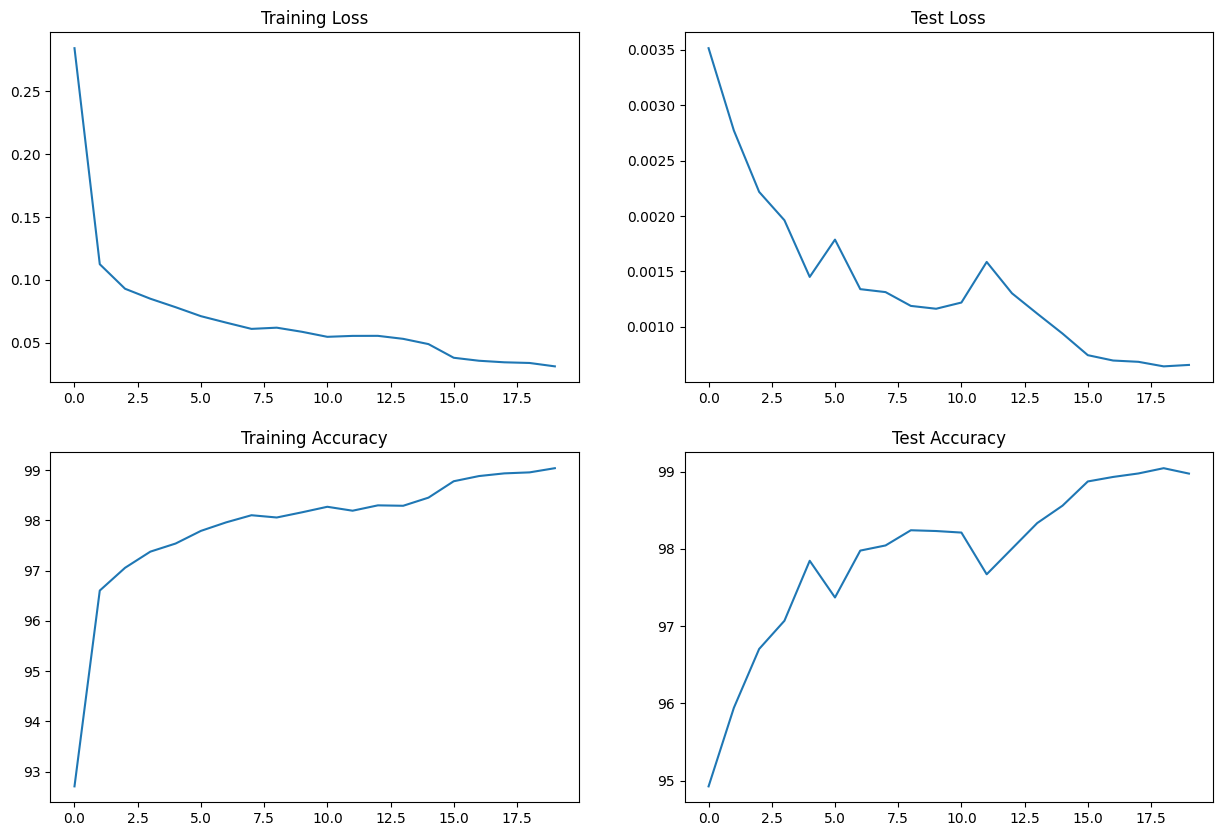

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 32, 24, 24]           9,248
       BatchNorm2d-3           [-1, 32, 24, 24]              64
       BatchNorm2d-4           [-1, 32, 12, 12]              64
            Conv2d-5           [-1, 48, 10, 10]          13,872
       BatchNorm2d-6             [-1, 48, 5, 5]              96
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Linear-8                   [-1, 10]             490
Total params: 24,154
Trainable params: 24,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.53
Params size (MB): 0.09
Estimated Total Size (MB): 0.62
----------------------------------------------------------------
